Import Libraries

In [1]:
from PyQt5.QtCore import *
import pandas as pd
from qgis.core import *
import os
import geopandas as gpd
import fiona
import sys
import math
import numpy
from shapely.geometry import shape
from shapely.geometry import Polygon
from rtree import index

In [2]:
# Increase width of notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Define functions to be used in script

In [3]:
# Create function to check for transect numbers of before and after points

def transectCheck(rownumber, dataframe):
    current = dataframe['Transect'].iloc[rownumber]
    after = dataframe['Transect'].iloc[rownumber + 1]
    if "/" in current:
        slash1 = current.find("/")
        slash2 = slash1 + 1
        current = current[slash2:]
    elif "," in current:
        slash1 = current.find(",")
        slash2 = slash1 + 1
        current = current[slash2:]
    else: pass
    
    if "/" in after:
        slash = after.find("/")
        after = after[:slash]
        
    elif "," in after:
        slash = after.find(",")
        after = after[:slash]
        
    else: pass
    
    if current == after:
        return 1
    else: return 0
    
    
# Create function to determine if a point is a mapping unit

def muCheck(rownumber, dataframe):
    # Check transects
    currentT = dataframe['Transect'].iloc[rownumber].replace(" ", "")
    currentT2 = dataframe['Transect'].iloc[rownumber].replace(" ", "")    
    beforeT = dataframe['Transect'].iloc[rownumber - 1].replace(" ", "")
    afterT = dataframe['Transect'].iloc[rownumber + 1].replace(" ", "")
    if "/" in currentT:
        slash1 = currentT.find("/")
        slash2 = slash1 + 1
        currentT = currentT[slash2:]
        currentT2 = currentT2[:slash1]
    else: pass
    if "/" in afterT:
        slash = afterT.find("/")
        afterT = afterT[:slash]
    else: pass
    if "/" in beforeT:
        slash3 = beforeT.find("/")
        slash4 = slash3 + 1
        beforeT = beforeT[slash4:]
    else: pass
    
    # Check subclasses
    currentS = dataframe['Subclass'].iloc[rownumber][:2]
    beforeS = dataframe['Subclass'].iloc[rownumber - 1][:2]
    afterS = dataframe['Subclass'].iloc[rownumber + 1][:2]
    
    # Check 'Notes' field for mu
    
    try:
        if "mu" in dataframe['Notes'].iloc[rownumber]: return 2
        
        else: pass
        
    except: pass
    try:
        if "Mu" in dataframe['Notes'].iloc[rownumber]: return 2
        
        else: pass
        
    except: pass
    try:
        if "MU" in dataframe['Notes'].iloc[rownumber]: return 2
        
        else: pass
        
    except: pass       
    
    if currentT == afterT and currentS == afterS: pass
    else:
            if currentT2 == beforeT and currentS == beforeS: pass
            else: return 2
            
def muCheck2(rownumber, dataframe):
    
    # Check again in case of ","
    currentT = dataframe['Transect'].iloc[rownumber].replace(" ", "")
    currentT2 = dataframe['Transect'].iloc[rownumber].replace(" ", "")    
    beforeT = dataframe['Transect'].iloc[rownumber - 1].replace(" ", "")
    afterT = dataframe['Transect'].iloc[rownumber + 1].replace(" ", "")
    if "," in currentT:
        slash1 = currentT.find(",")
        slash2 = slash1 + 1
        currentT = currentT[slash2:]
        currentT2 = currentT2[:slash1]
    else: pass
    if "," in afterT:
        slash = afterT.find(",")
        afterT = afterT[:slash]
    else: pass
    if "," in beforeT:
        slash3 = beforeT.find(",")
        slash4 = slash3 + 1
        beforeT = beforeT[slash4:]
    else: pass
    
    # Check subclasses
    currentS = dataframe['Subclass'].iloc[rownumber][:2]
    beforeS = dataframe['Subclass'].iloc[rownumber - 1][:2]
    afterS = dataframe['Subclass'].iloc[rownumber + 1][:2]
    
    # Check 'Notes' field for mu
    

    if currentT == afterT and currentS == afterS: pass
    else:
            if currentT2 == beforeT and currentS == beforeS: pass
            else: return 2
    
    
            
def muClassCheck(rownumber, dataframe):
    # Check transects
    currentT = dataframe['Transect'].iloc[rownumber]
    currentT2 = dataframe['Transect'].iloc[rownumber]    
    beforeT = dataframe['Transect'].iloc[rownumber - 1]
    afterT = dataframe['Transect'].iloc[rownumber + 1]
    if "/" in currentT:
        slash1 = currentT.find("/")
        slash2 = slash1 + 1
        currentT = currentT[slash2:]
        currentT2 = currentT2[:slash1]
    else: pass
    if "/" in afterT:
        slash = afterT.find("/")
        afterT = afterT[:slash]
    else: pass
    if "/" in beforeT:
        slash3 = beforeT.find("/")
        slash4 = slash3 + 1
        beforeT = beforeT[slash4:]
    else: pass
    
    # Check subclasses
    currentS = dataframe['Class'].iloc[rownumber]
    beforeS = dataframe['Class'].iloc[rownumber - 1]
    afterS = dataframe['Class'].iloc[rownumber + 1]

    if currentT == afterT and currentS == afterS: pass
    else:
            if currentT2 == beforeT and currentS == beforeS: pass
            else: return 2
            
def muCheckLast(rownumber, dataframe):
    # Check final subclass with [-1] subclass only
    currentS = dataframe['Subclass'].iloc[rownumber][:2]
    beforeS = dataframe['Subclass'].iloc[rownumber - 1][:2]
    
    if currentS == beforeS: pass
    else: return 2
    
def muClassCheckLast(rownumber, dataframe):
    # Check final subclass with [-1] subclass only
    currentS = dataframe['Class'].iloc[rownumber][:2]
    beforeS = dataframe['Class'].iloc[rownumber - 1][:2]
    
    if currentS == beforeS: pass
    else: return 2

# Define function to test whether angle of mu corresponds to pre or post angle

def prepostCheck(rownumber, dataframe):
    currentT = dataframe['Transect'].iloc[rownumber]
    afterT = dataframe['Transect'].iloc[rownumber + 1]
    
    if "/" in currentT:
        slash1 = currentT.find("/")
        slash2 = slash1 + 1
        currentT = currentT[slash2:]
    else: pass
    
    if "/" in afterT:
        slash = afterT.find("/")
        afterT = afterT[:slash]
    else: pass
    
    if currentT == afterT: return "post"
    else: return "pre"
    
    

Set Up the Data - Specify correct folders to be generated

In [4]:
# Create directories within selected folder

# If tapping into Google Drive, folder may need to be availble offline

root = input("Enter file path to site folder in EPA Salt Marsh UAS Study with quotations -- ")
root = root[1:-1]
base = root + "\Jupyter_Working_Folder"
workIn = input("Enter in the date and site in the format: RR_14_Aug_2019 -- ")
currentWork = base + "\\" + workIn
XY_Points_Folder = currentWork + "\XY_Points"
Lines_Folder = currentWork + "\Lines"
Buffer_Folder = currentWork + "\Lines_Buffered"
Class_Lines_Folder = currentWork + "\Class_Lines"
Class_Buffer_Folder = currentWork + "\Class_Lines_Buffered"
mu_Folder = currentWork + "\mu"
mu_Buffer_Folder = currentWork + "\mu_Buffered"
working = currentWork + "\working"
Polygon_Folder = currentWork + "\Polygons"
folderList = [currentWork, XY_Points_Folder, Lines_Folder, Buffer_Folder, mu_Folder, 
              mu_Buffer_Folder, Class_Lines_Folder, Class_Buffer_Folder, working, Polygon_Folder]
for i in folderList:
    if not os.path.exists(i):
        os.makedirs(i)
        print(str(i) + " created.")
print("Folder creation complete.")

Enter file path to site folder in EPA Salt Marsh UAS Study with quotations -- "G:\.shortcut-targets-by-id\0B6-MI-dco6FLWkZmTDZ4MFhRU1k\7. SaltMUAS_share\EPA Salt Marsh UAS Study\Essex Bay"
Enter in the date and site in the format: RR_14_Aug_2019 -- Essex_2_Jun_2021
G:\.shortcut-targets-by-id\0B6-MI-dco6FLWkZmTDZ4MFhRU1k\7. SaltMUAS_share\EPA Salt Marsh UAS Study\Essex Bay\Jupyter_Working_Folder\Essex_2_Jun_2021 created.
G:\.shortcut-targets-by-id\0B6-MI-dco6FLWkZmTDZ4MFhRU1k\7. SaltMUAS_share\EPA Salt Marsh UAS Study\Essex Bay\Jupyter_Working_Folder\Essex_2_Jun_2021\XY_Points created.
G:\.shortcut-targets-by-id\0B6-MI-dco6FLWkZmTDZ4MFhRU1k\7. SaltMUAS_share\EPA Salt Marsh UAS Study\Essex Bay\Jupyter_Working_Folder\Essex_2_Jun_2021\Lines created.
G:\.shortcut-targets-by-id\0B6-MI-dco6FLWkZmTDZ4MFhRU1k\7. SaltMUAS_share\EPA Salt Marsh UAS Study\Essex Bay\Jupyter_Working_Folder\Essex_2_Jun_2021\Lines_Buffered created.
G:\.shortcut-targets-by-id\0B6-MI-dco6FLWkZmTDZ4MFhRU1k\7. SaltMUAS_sha

Check data to edit cell below to determine number of rows to exclude

In [5]:
# Read in .cvs with Transects
# Keep quotations around file path in the input
read_data = input("Enter file path to ground truthing data .csv here -- ")
read_data = read_data[1:-1]

# skiprows argument may need to be tweaked depending on format of the .csv's headers
df = pd.read_csv(read_data)

Enter file path to ground truthing data .csv here -- "G:\.shortcut-targets-by-id\0B6-MI-dco6FLWkZmTDZ4MFhRU1k\7. SaltMUAS_share\EPA Salt Marsh UAS Study\Essex Bay\Ground Truthing\essex2june2021_revised_line.csv"


In [6]:
# Observe number of rows to discard including RTC data
print("Preview of data:")
df.head()

Preview of data:


,PolygonNum,PointNum,Subclass,Northing,Easting,Altitude,Notes
0,1,1,06a,4724010.106,354917.469,1.240,line
1,1,2,06a,4723995.662,354917.782,1.231,line
2,2,3,05a,4723993.626,354917.795,1.220,1 mu
3,3,4,04a,4723991.731,354918.051,1.211,line
4,3,5,04a,4723985.416,354917.757,1.214,line


In [7]:
# Remove top rows of data if necessary
dat = input("If dataframe start at the correct positional row, enter 1, if not, enter 2 -- ")
if dat == "2":
    num = int(input("Enter in number of rows to discard -- "))
    if num == 1:
        datos = df.iloc[1:]
        dato = pd.DataFrame(datos)
        print("One row discarded")
    elif num == 2:
        datos = df.iloc[2:]
        dato = pd.DataFrame(datos)  
        print("Two rows discarded")
    elif num == 3:
        datos = df.iloc[3:]
        dato = pd.DataFrame(datos) 
        print("Three rows discarded")
    else:
        datos = df.iloc[4:]
        dato = pd.DataFrame(datos)  
        print("Rows discarded")
else: dato = pd.DataFrame(df)
dato.head()

If dataframe start at the correct positional row, enter 1, if not, enter 2 -- 1


,PolygonNum,PointNum,Subclass,Northing,Easting,Altitude,Notes
0,1,1,06a,4724010.106,354917.469,1.240,line
1,1,2,06a,4723995.662,354917.782,1.231,line
2,2,3,05a,4723993.626,354917.795,1.220,1 mu
3,3,4,04a,4723991.731,354918.051,1.211,line
4,3,5,04a,4723985.416,354917.757,1.214,line


In [8]:
# Rename column headers
try:
    dato.columns = ['Transect', 'Point Number', 'Subclass', 'Northing', 'Easting', 'Altitude', 'Notes']
except:
    dato.columns = ['Transect', 'Point Number', 'Subclass', 'Northing', 'Easting', 'Altitude', 'Notes', 'Field Notes']
    

In [9]:
dato

,Transect,Point Number,Subclass,Northing,Easting,Altitude,Notes
0,1,1,06a,4724010.106,354917.469,1.240,line
1,1,2,06a,4723995.662,354917.782,1.231,line
2,2,3,05a,4723993.626,354917.795,1.220,1 mu
3,3,4,04a,4723991.731,354918.051,1.211,line
4,3,5,04a,4723985.416,354917.757,1.214,line
5,4,6,05a,4723983.547,354917.603,1.191,line
6,4,7,05a,4723980.273,354917.519,1.213,line
7,5,8,04a,4723978.377,354917.463,1.213,line
8,5,9,04a,4723960.955,354916.317,1.112,line
9,6,10,05a,4723958.723,354916.235,1.125,line


In [10]:
filter_dato = dato[dato['Transect'].notnull()]

In [11]:
# Filter for null values where Transect != NaN 
filter_dato2 = dato[dato['Transect'].isnull()]

In [12]:
filter_dato2['Transect']

Series([], Name: Transect, dtype: int64)

In [13]:
# Create empty fields for transect angles, Class, and mapping unit

filter_dato['Class'] = ""
filter_dato["Raw Subclass"] = ""
filter_dato['Pre Angle'] = ""
filter_dato['Post Angle'] = ""
filter_dato['mu'] = ""
filter_dato['Class mu'] = ""
filter_dato["Pre/Post"] = ""


# Preview the data
filter_dato.head()

,Transect,Point Number,Subclass,Northing,Easting,Altitude,Notes,Class,Raw Subclass,Pre Angle,Post Angle,mu,Class mu,Pre/Post
0,1,1,06a,4724010.106,354917.469,1.240,line,,,,,,,
1,1,2,06a,4723995.662,354917.782,1.231,line,,,,,,,
2,2,3,05a,4723993.626,354917.795,1.220,1 mu,,,,,,,
3,3,4,04a,4723991.731,354918.051,1.211,line,,,,,,,
4,3,5,04a,4723985.416,354917.757,1.214,line,,,,,,,


In [15]:
# Use this cell to alter the data if needed

input("Press Enter after confirming cell alters data as needed; stop running Notebook if not")



Press Enter after confirming cell alters data as needed; stop running Notebook if not


''

In [16]:
tList = filter_dato['Transect'].tolist()

In [17]:
tList = list(map(str, tList))

In [18]:
tList2 = []
for i in tList:
    tList2.append(i.replace(".0", ""))

In [19]:
tList2

['1',
 '1',
 '2',
 '3',
 '3',
 '4',
 '4',
 '5',
 '5',
 '6',
 '6',
 '7',
 '7',
 '8',
 '8',
 '9',
 '9',
 '9',
 '9',
 '10',
 '10',
 '10',
 '11',
 '11',
 '12',
 '12']

In [20]:
# Convert any strings to floats or ints

filter_dato['Transect'] = tList2
filter_dato['Point Number'] = list(map(int, filter_dato['Point Number']))
filter_dato['Northing'] = list(map(float, filter_dato['Northing']))
filter_dato['Easting'] = list(map(float, filter_dato['Easting']))
filter_dato['Altitude'] = list(map(float, filter_dato['Altitude']))

In [21]:
filter_dato.dtypes

Transect         object
Point Number      int64
Subclass         object
Northing        float64
Easting         float64
Altitude        float64
Notes            object
Class            object
Raw Subclass     object
Pre Angle        object
Post Angle       object
mu               object
Class mu         object
Pre/Post         object
dtype: object

In [22]:
# Define variables of lists of coordinates of current, before, and after coordinates
# This will be used to calculate angle from one point to the next

y = 0
precoordN = []
for x in filter_dato.iterrows():
    precoordN.append(filter_dato['Northing'].iloc[y-1])
    y += 1
y = 0
precoordE = []
for x in filter_dato.iterrows():
    precoordE.append(filter_dato['Easting'].iloc[y-1])
    y += 1
y = 0
currcoordN = []
for x in filter_dato.iterrows():
    currcoordN.append(filter_dato['Northing'].iloc[y])
    y += 1
y = 0
currcoordE = []
for x in filter_dato.iterrows():
    currcoordE.append(filter_dato['Easting'].iloc[y])
    y += 1
y = 0
postcoordN = []
for x in filter_dato.iterrows():
    if y+1 < len(filter_dato):
        postcoordN.append(filter_dato['Northing'].iloc[y+1])
        y += 1
    else: break
y = 0
postcoordE = []
for x in filter_dato.iterrows():
    if y+1 < len(filter_dato):
        postcoordE.append(filter_dato['Easting'].iloc[y+1])
        y += 1
    else: break

In [23]:
# # Convert any strings to floats

# precoordN = list(map(float, precoordN))
# precoordE = list(map(float, precoordE))
# currcoordN = list(map(float, currcoordN))
# currcoordE = list(map(float, currcoordE))
# postcoordN = list(map(float, postcoordN))
# postcoordE = list(map(float, postcoordE))

In [24]:
# Append calculated angles to lists
y = 0
preAngle = []
for i in filter_dato.iterrows():
    if y-1 < 0:
        preAngle.append(0)
        y += 1
    else:
        myradians = math.atan2(currcoordN[y]-precoordN[y], currcoordE[y]-precoordE[y])
        mydegrees = math.degrees(myradians)
        preAngle.append(mydegrees)
        y += 1

y = 0
postAngle = []
for i in filter_dato.iterrows():
    if y+1 < len(filter_dato):
        myradians = math.atan2(postcoordN[y]-currcoordN[y], postcoordE[y]-currcoordE[y])
        mydegrees = math.degrees(myradians)
        postAngle.append(mydegrees)
        y += 1
    else: 
        postAngle.append(0)
        y += 1       

In [25]:
# Parse out Class from Subclass and append to new list

classe = []
y = 0
for i in filter_dato.iterrows():
    if filter_dato['Subclass'].iloc[y][:1] == "0" or filter_dato['Subclass'].iloc[y][:1] == "1":
        classe.append(1)
        y += 1
    elif filter_dato['Subclass'].iloc[y][:1] == "2":
        classe.append(2)
        y += 1
    elif filter_dato['Subclass'].iloc[y][:1] == "3":
        classe.append(3)
        y += 1
    else:
        classe.append(9999)

In [26]:
classe

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [27]:
# Parse out Raw Subclass data with only letters - no attribute letters

subraw = []
y = 0
for i in filter_dato["Subclass"]:
    subraw.append(str(i[:2]))

In [28]:
# Add lists to empty columns

filter_dato['Pre Angle'] = preAngle
filter_dato['Post Angle'] = postAngle
filter_dato['Class'] = classe
filter_dato["Raw Subclass"] = subraw

In [29]:
x = 0
for i in filter_dato['Transect']:
    print(type(filter_dato['Transect'].iloc[x]))
    x += 1

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


In [30]:

filter_dato

,Transect,Point Number,Subclass,Northing,Easting,Altitude,Notes,Class,Raw Subclass,Pre Angle,Post Angle,mu,Class mu,Pre/Post
0,1,1,06a,4724010.106,354917.469,1.240,line,1,06,0.000000,-88.758601,,,
1,1,2,06a,4723995.662,354917.782,1.231,line,1,06,-88.758601,-89.634167,,,
2,2,3,05a,4723993.626,354917.795,1.220,1 mu,1,05,-89.634167,-82.306356,,,
3,3,4,04a,4723991.731,354918.051,1.211,line,1,04,-82.306356,-92.665527,,,
4,3,5,04a,4723985.416,354917.757,1.214,line,1,04,-92.665527,-94.710360,,,
5,4,6,05a,4723983.547,354917.603,1.191,line,1,05,-94.710360,-91.469698,,,
6,4,7,05a,4723980.273,354917.519,1.213,line,1,05,-91.469698,-91.691789,,,
7,5,8,04a,4723978.377,354917.463,1.213,line,1,04,-91.691789,-93.763432,,,
8,5,9,04a,4723960.955,354916.317,1.112,line,1,04,-93.763432,-92.104006,,,
9,6,10,05a,4723958.723,354916.235,1.125,line,1,05,-92.104006,-93.783263,,,


In [31]:
# Create new shapefile for Points that do not create a line
y = 0
muList = []

# for loop to write point for every mapping unit
for feat in filter_dato.iterrows():

    # Create if statement so you y is never > the length of your data set; this will end your script
    if y + 1 < len(filter_dato):
#         if filter_dato['Raw Subclass'].iloc[y] == "13":
#             muList.append(1)
#             print("thirteen")
#         else:
        if muCheck(y, filter_dato) == 2:
            muList.append(1)
            print("mu")



            y += 1
        else: 
            muList.append(0)
            y += 1
            print("not mu")
muList.append(1)        
        
# Repeart for Class mapping units

y = 0
ClassmuList = []
for feat in filter_dato.iterrows():
    if y + 1 < len(filter_dato):
        if muClassCheck(y, filter_dato) == 2:
            ClassmuList.append(1)
            
            

            y += 1
        else: 
            ClassmuList.append(0)
            y += 1
    else:
        ClassmuList.append(1)

not mu
not mu
mu
not mu
not mu
not mu
not mu
not mu
not mu
not mu
not mu
not mu
not mu
not mu
not mu
not mu
not mu
not mu
not mu
not mu
not mu
not mu
not mu
not mu
not mu


In [32]:
muList

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [33]:
# Append muList to dataframe
filter_dato['mu'] = muList
filter_dato['Class mu'] = ClassmuList

In [34]:
filter_dato["mu"]

0     0
1     0
2     1
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    1
Name: mu, dtype: int64

In [35]:
input("Keep value as zero if the last point in the data is not a mapping unit. Press Enter. ")
filter_dato['mu'][-1:] = 0

Keep value as zero if the last point in the data is not a mapping unit. Press Enter. 


C:\Users\brett\anaconda3\envs\CAFE\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [36]:
# Create for loop to create list of pre or post to append to dataframe
# This angle determines the angle the mapping unit should be rotated

y = 0
prepost = []

for i in filter_dato.iterrows():
    if y + 1 < len(filter_dato):
        pp = prepostCheck(y, filter_dato)
        prepost.append(pp)
        y += 1
    else: prepost.append("pre")

In [37]:
# Append prepost list to dataframe

filter_dato["Pre/Post"] = prepost

In [38]:
# Remove extra spaces from transect column

# Create list of 'Transect' column

tLists = filter_dato['Transect'].tolist()

# Replace spaces with no space

tList2 = []
for i in tLists:
    tList2.append(i.replace(" ", ""))
    
# Append list to column

filter_dato['Transect'] = tList2

In [39]:
# Create QGIS XY Point Data into a List based on coordinates
point_list = [QgsPointXY(r['Easting'], r['Northing']) for i, r in filter_dato.iterrows() ]

In [40]:
# Create Multipoint list
points = QgsGeometry.fromMultiPointXY(point_list)

Create the XY Point Shapefile

In [41]:
# Create fields with correct data types

layerFields = QgsFields()
layerFields.append(QgsField('Transect', QVariant.String))
layerFields.append(QgsField('PointNum', QVariant.Int))
layerFields.append(QgsField('SubClass', QVariant.String))
layerFields.append(QgsField('Northing', QVariant.Double))
layerFields.append(QgsField('Easting', QVariant.Double))
layerFields.append(QgsField('Altitude', QVariant.Double))
layerFields.append(QgsField('Notes', QVariant.String))
layerFields.append(QgsField('Class', QVariant.Int))
layerFields.append(QgsField('Raw Subclass', QVariant.String))
layerFields.append(QgsField('Pre Angle', QVariant.Double))
layerFields.append(QgsField('Post Angle', QVariant.Double))
layerFields.append(QgsField('mu', QVariant.Int))
layerFields.append(QgsField('Class mu', QVariant.Int))
layerFields.append(QgsField('Pre/Post', QVariant.String))



True

In [42]:
# Set attributes by assigning to list assigned to variable
attributeList = [filter_dato['Transect'].iloc[y], \
                 int(filter_dato['Point Number'].iloc[y]), \
                 filter_dato['Subclass'].iloc[y], \
                 filter_dato['Northing'].iloc[y].item(), \
                 filter_dato['Easting'].iloc[y].item(), \
                 filter_dato['Altitude'].iloc[y].item(), \
                 filter_dato['Notes'].iloc[y], \
                 filter_dato['Class'].iloc[y].item(), \
                 filter_dato['Raw Subclass'].iloc[y], \
                 filter_dato['Pre Angle'].iloc[y].item(), \
                 filter_dato['Post Angle'].iloc[y].item(), \
                 filter_dato['mu'].iloc[y].item(),  \
                 filter_dato['Class mu'].iloc[y].item(), \
                 filter_dato['Pre/Post'].iloc[y]]

In [43]:
# Write XY Point Data for each row in .csv
# Specify output to variable
XY_Output_Path = XY_Points_Folder

In [44]:
# Use for loop to create shapefile
y = 0
for x in filter_dato.itertuples():
    # Specify file output and name of .shp
    file = XY_Output_Path + "\XYPoint" + str(y) + ".shp"
    # Set type (QgsWkbTypes.), CRS (EPSG:26919), and type of file (ESRI Shapefile)
    writer = QgsVectorFileWriter(file, 'UTF-8', layerFields, QgsWkbTypes.MultiPoint, QgsCoordinateReferenceSystem('EPSG:26919'), 'ESRI Shapefile')
    # Appends X and Y coordinates to variable 'point1' at the y position (starts at 0 and adds 1 for each iteration of the for loop)
    point1 = QgsGeometry.fromPointXY(point_list[y])
    # Create an empty feature
    feat = QgsFeature()
    # Set feature's geometry to that of point1
    feat.setGeometry(point1)
    # Set values from dataframe to attributes
    # Values will be applied in the order you created the layerFields
    feat.setAttributes([filter_dato['Transect'].iloc[y], \
                 int(filter_dato['Point Number'].iloc[y]), \
                 filter_dato['Subclass'].iloc[y], \
                 filter_dato['Northing'].iloc[y].item(), \
                 filter_dato['Easting'].iloc[y].item(), \
                 filter_dato['Altitude'].iloc[y].item(), \
                 filter_dato['Notes'].iloc[y], \
                 filter_dato['Class'].iloc[y].item(), \
                 filter_dato['Raw Subclass'].iloc[y], \
                 filter_dato['Pre Angle'].iloc[y].item(), \
                 filter_dato['Post Angle'].iloc[y].item(), \
                 filter_dato['mu'].iloc[y].item(),  \
                 filter_dato['Class mu'].iloc[y].item(), \
                 filter_dato['Pre/Post'].iloc[y]])
    # Add 1 to y to continue through the dataframe during next for loop
    y += 1
    # write the feature
    writer.addFeature(feat)

del(writer)

C:\Users\brett\anaconda3\envs\CAFE\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: QgsVectorFileWriter constructor is deprecated
  import sys


Concatenate all XY Point shapefiles into a single shapefile

In [45]:
# Specify which folder to look in
file = os.listdir(XY_Output_Path)

# Look for all files ending in ".shp"
path = [os.path.join(XY_Output_Path, i) for i in file if ".shp" in i]

# Concatenate to file specified in last line of code
gdf = gpd.GeoDataFrame(pd.concat([gpd.read_file(i) for i in path],
                        ignore_index=True), crs=gpd.read_file(path[0]).crs)
# Write to same folder + name of new folder to be created which will include the shapefile of compiled XY Points
XY_Points_Comp = "\XY_Points_Comp"

In [46]:
# Write concatenated files to output path
gdf.to_file(XY_Output_Path + XY_Points_Comp )

In [47]:
# Sort shapefile by Point Number attribute
# Assign XY_Points__Outfile to where the sorted compiled XY Points will be saved
XY_Points_outfile = XY_Output_Path + XY_Points_Comp + "\\XY_Points_Comp_Sort.shp"
# Designate which compiled shapefile will be sorted
filePath = XY_Output_Path + XY_Points_Comp + XY_Points_Comp + ".shp"
# Use geopandas to read in shapefile - Append read shapefile to variable 'shape'
shape = gpd.read_file(filePath)
# Sort based on Point Number
shape_sort = shape.iloc[shape['PointNum'].sort_values().index.values]

In [48]:
# Re-write file back out as sorted compiled shapefile
shape_sort.to_file(driver = 'ESRI Shapefile', filename = XY_Points_outfile)

Create PolyLine Shapefile

In [49]:
# Specify empty folder to put the Line files in
linesFolder = Lines_Folder
classlinesFolder = Class_Lines_Folder

In [50]:
# create variable to iterate through
shape = fiona.open(XY_Points_outfile)

In [51]:
# Create lines based on subclasses

# for loop to write line file between every 2 sequential points with matching sublass
y = 0
for feat in shape:
    # Create if statement so you y is never > the length of your data set; this will end your script
    if y + 1 < len(filter_dato):
        # What file to write
        file = linesFolder + "\line_" + str(y) + ".shp"
        # Same as previous writer, except QgsWkbTypes. is LineString
        writer = QgsVectorFileWriter(file, 'UTF-8', layerFields, QgsWkbTypes.LineString, \
                                 QgsCoordinateReferenceSystem('EPSG:26919'), 'ESRI Shapefile')
        # y point in point_list will act as the start of the line
        lineStart = point_list[y]
        # y + 1 point in point_list will act as the end of the line
        lineEnd = point_list[y+1]
        # Creates line based on the start and end points previously specified
        line = QgsGeometry.fromPolylineXY([lineStart, lineEnd])
        # Create empty feature for line
        linef = QgsFeature()
        # Set geometry to previously created PolyLine
        linef.setGeometry(line)
        # Append attributes from dataframe
        # Since the Line will consist of 2 points, both points' attributes must be stored in the line
        linef.setAttributes([filter_dato['Transect'].iloc[y], \
                 int(filter_dato['Point Number'].iloc[y]), \
                 filter_dato['Subclass'].iloc[y], \
                 filter_dato['Northing'].iloc[y].item(), \
                 filter_dato['Easting'].iloc[y].item(), \
                 filter_dato['Altitude'].iloc[y].item(), \
                 filter_dato['Notes'].iloc[y], \
                 filter_dato['Class'].iloc[y].item(), \
                 filter_dato['Raw Subclass'].iloc[y], \
                 filter_dato['Pre Angle'].iloc[y].item(), \
                 filter_dato['Post Angle'].iloc[y].item(), \
                 filter_dato['mu'].iloc[y].item(),  \
                 filter_dato['Class mu'].iloc[y].item(), \
                 filter_dato['Pre/Post'].iloc[y]])
        # if statement so a line is only written if it belongs to the same transect
        if filter_dato['Subclass'].iloc[y][:2] == filter_dato['Subclass'].iloc[y+1][:2] and transectCheck(y,filter_dato) == 1:
            if filter_dato['mu'].iloc[y] == 1:
                y +=1
            else:
                writer.addFeature(linef)
                y += 1
        else:
            y += 1
    else: break
del(writer)

C:\Users\brett\anaconda3\envs\CAFE\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: QgsVectorFileWriter constructor is deprecated
  if sys.path[0] == '':


In [52]:
# # Create lines based on Class

# # for loop to write line file between every 2 sequential points with matching Class
# y = 0
# for feat in shape:
#     # Create if statement so you y is never > the length of your data set; this will end your script
#     if y + 1 < len(filter_dato):
#         # What file to write
#         file = classlinesFolder + "\line_" + str(y) + ".shp"
#         # Same as previous writer, except QgsWkbTypes. is LineString
#         writer = QgsVectorFileWriter(file, 'UTF-8', layerFields, QgsWkbTypes.LineString, \
#                                  QgsCoordinateReferenceSystem('EPSG:26919'), 'ESRI Shapefile')
#         # y point in point_list will act as the start of the line
#         lineStart = point_list[y]
#         # y + 1 point in point_list will act as the end of the line
#         lineEnd = point_list[y+1]
#         # Creates line based on the start and end points previously specified
#         line = QgsGeometry.fromPolylineXY([lineStart, lineEnd])
#         # Create empty feature for line
#         linef = QgsFeature()
#         # Set geometry to previously created PolyLine
#         linef.setGeometry(line)
#         # Append attributes from dataframe
#         # Since the Line will consist of 2 points, both points' attributes must be stored in the line
#         linef.setAttributes([filter_dato['Transect'].iloc[y], \
#                  int(filter_dato['Point Number'].iloc[y]), \
#                  filter_dato['Subclass'].iloc[y], \
#                  filter_dato['Northing'].iloc[y].item(), \
#                  filter_dato['Easting'].iloc[y].item(), \
#                  filter_dato['Altitude'].iloc[y].item(), \
#                  filter_dato['Notes'].iloc[y], \
#                  filter_dato['Class'].iloc[y].item(), \
#                  filter_dato['Raw Subclass'].iloc[y], \
#                  filter_dato['Pre Angle'].iloc[y].item(), \
#                  filter_dato['Post Angle'].iloc[y].item(), \
#                  filter_dato['mu'].iloc[y].item(),  \
#                  filter_dato['Class mu'].iloc[y].item(), \
#                  filter_dato['Pre/Post'].iloc[y]])
#         # if statement so a line is only written if it belongs to the same transect
#         if filter_dato['Class'].iloc[y] == filter_dato['Class'].iloc[y+1] and transectCheck(y,filter_dato) == 1:
#             writer.addFeature(linef)
#             y += 1
#         else:
#             y += 1
#     else: break
# del(writer)

In [75]:
# Create mapping units based on subclasses

# Create new shapefile for Points that do not create a line

y = 0
shape = gpd.read_file(XY_Points_outfile)
muList2 = filter_dato['mu'].to_list()

# for loop to write point for every mapping unit
for i in muList2:
    # Create if statement so you y is never > the length of your data set; this will end your script
    if i == 1:
        print("We are currently making a MU")
        print(i)
            
        # What file to write
        file = mu_Folder + "\mu_" + str(y) + ".shp"
        # Same as previous writer, except QgsWkbTypes. is Polygon
        writer = QgsVectorFileWriter(file, 'UTF-8', layerFields, QgsWkbTypes.MultiPoint, \
                                QgsCoordinateReferenceSystem('EPSG:26919'), 'ESRI Shapefile')
        poly1 = QgsGeometry.fromPointXY(point_list[y])
        feat1 = QgsFeature()
        feat1.setGeometry(poly1)
        feat1.setAttributes([filter_dato['Transect'].iloc[y], \
                 int(filter_dato['Point Number'].iloc[y]), \
                 filter_dato['Subclass'].iloc[y], \
                 filter_dato['Northing'].iloc[y].item(), \
                 filter_dato['Easting'].iloc[y].item(), \
                 filter_dato['Altitude'].iloc[y].item(), \
                 filter_dato['Notes'].iloc[y], \
                 filter_dato['Class'].iloc[y].item(), \
                 filter_dato['Raw Subclass'].iloc[y], \
                 filter_dato['Pre Angle'].iloc[y].item(), \
                 filter_dato['Post Angle'].iloc[y].item(), \
                 filter_dato['mu'].iloc[y].item(),  \
                 filter_dato['Class mu'].iloc[y].item(), \
                 filter_dato['Pre/Post'].iloc[y]])
        y += 1
        writer.addFeature(feat1)
    else: 
        y += 1
del(writer)

We are currently making a MU
1


C:\Users\brett\anaconda3\envs\CAFE\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: QgsVectorFileWriter constructor is deprecated


In [76]:
# Create list of folders that contain newly created shapefiles to iterate through
concat_list = [linesFolder, mu_Folder]


# Concat lines
file = os.listdir(linesFolder)
path = [os.path.join(linesFolder, x) for x in file if ".shp" in x]
gdf = gpd.GeoDataFrame(pd.concat([gpd.read_file(x) for x in path],
                                    ignore_index=True), crs=gpd.read_file(path[0]).crs)
gdf.to_file(linesFolder + "\\Lines_Comp")

# Concat mu
try:
    file = os.listdir(mu_Folder)
    path = [os.path.join(mu_Folder, x) for x in file if ".shp" in x]
    gdf = gpd.GeoDataFrame(pd.concat([gpd.read_file(x) for x in path],
                                        ignore_index=True), crs=gpd.read_file(path[0]).crs)
    gdf.to_file(mu_Folder + "\\mu_Comp")
    
    is_mu = "yes"
# gdf.to_file(i + "\\Class_Lines_Comp")
    
except:
    print("There are no mapping units to concatenate")
    is_mu = "no"

In [77]:
if is_mu == "yes":
    
    concat_fileList = [linesFolder + "\\Lines_Comp\\Lines_Comp.shp",
                   mu_Folder + "\\mu_Comp\\mu_Comp.shp"]
elif is_mu == "no": 
    concat_fileList = [linesFolder + "\\Lines_Comp\\Lines_Comp.shp"]
else:
    print("Unknown error")

In [78]:
concat_fileList

['G:\\.shortcut-targets-by-id\\0B6-MI-dco6FLWkZmTDZ4MFhRU1k\\7. SaltMUAS_share\\EPA Salt Marsh UAS Study\\Essex Bay\\Jupyter_Working_Folder\\Essex_2_Jun_2021\\Lines\\Lines_Comp\\Lines_Comp.shp',
 'G:\\.shortcut-targets-by-id\\0B6-MI-dco6FLWkZmTDZ4MFhRU1k\\7. SaltMUAS_share\\EPA Salt Marsh UAS Study\\Essex Bay\\Jupyter_Working_Folder\\Essex_2_Jun_2021\\mu\\mu_Comp\\mu_Comp.shp']

Buffer time

In [79]:
# Buffer lines

# Assign empty folder to variable to write new file to
linesBufferFolder = Buffer_Folder
# Read in line shapefile of transects
lines= gpd.read_file(concat_fileList[0])
# Assign buffer and keep attributes
lines['geometry'] = lines.buffer(1, cap_style=3)
# Write new shapefile
lines.to_file(linesBufferFolder + "\\Lines_Buffer")

# # Buffer Class lines

# # Assign empty folder to variable to write new file to
# classlinesBufferFolder = Class_Buffer_Folder
# # Read in line shapefile of transects
# lines= gpd.read_file(concat_fileList[1])
# # Assign buffer and keep attributes
# lines['geometry'] = lines.buffer(1, cap_style=3)
# # Write new shapefile
# lines.to_file(classlinesBufferFolder + "\\Class_Lines_Buffer")

In [80]:
# Buffer the mapping units
try:
    # Specify which folder to look in to buffer mu
    file = os.listdir(mu_Folder)

    # Assign empty folder to variable to write new file to
    muBufferFolder = mu_Buffer_Folder

    # Begin buffer by iterating through each mapping unit
    path = [os.path.join(mu_Folder, i) for i in file if ".shp" in i]
    y = 0
    for i in path:
        mus = gpd.read_file(path[y])
        if mus['Pre/Post'][0] == "post": 
            mus['geometry'] = mus.buffer(1, cap_style=3).rotate(mus["Post Angle"][0], origin='center')
            mus.to_file(muBufferFolder + "\\mu_" + str(mus["PointNum"][0]) + "_Buffer.shp")
        else: 
            mus['geometry'] = mus.buffer(1, cap_style=3).rotate(mus["Pre Angle"][0], origin='center')
            mus.to_file(muBufferFolder + "\\mu_" + str(mus["PointNum"][0]) + "_Buffer.shp")
        y += 1
except: 
    print("No mapping units")

In [81]:
# Concatenate mapping units
try:
    # Specify which folder to look in to compile mu
    file = os.listdir(muBufferFolder)

    # Look for all files ending in ".shp"
    path = [os.path.join(muBufferFolder, i) for i in file if ".shp" in i]

    # Concatenate to file specified in last line of code
    gdf = gpd.GeoDataFrame(pd.concat([gpd.read_file(i) for i in path],
                            ignore_index=True), crs=gpd.read_file(path[0]).crs)
    # Write to same folder + name of new folder to be created which will include the shapefile of compiled XY Points
    # Variable below is the suffix to add to linesFolder to specify folder to store compiled line files
    muCompSuff = "\\mu_Comp"
    gdf.to_file(muBufferFolder + muCompSuff)
    
except:
    print("No mapping units")

Erase the Duplicate Overlapping Data

In [82]:
# Import libraries needed for erase

from itertools import combinations
from shapely.geometry import LineString
import matplotlib

In [83]:
# Read in transect polygons as GeoDataFrame

polygdf = gpd.GeoDataFrame.from_file(linesBufferFolder + "\\Lines_Buffer")

In [84]:
# Use itertools to iterate through all polys within shapefile by combination

for p1_idx, p2_idx in combinations(polygdf.geometry.index, 2):
    if polygdf.geometry.loc[p1_idx].intersects(polygdf.geometry.loc[p2_idx]):
        # Store intermediary results back to poly
        polygdf.geometry.loc[p2_idx] -= polygdf.geometry.loc[p1_idx]
# polygdf is now saved with the new geometry where it does not overlap itself

<AxesSubplot:>

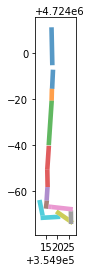

In [85]:
# Preview polygons using matplotlib
polygdf.plot(alpha=0.75, cmap="tab10")

In [86]:
try:
    mugdf = gpd.GeoDataFrame.from_file(muBufferFolder + muCompSuff)
except:
    print("There are no mapping units")

In [87]:
try:
    for mu_idx in mugdf.geometry.index:
        for p1_idx in polygdf.geometry.index:
            if mugdf.geometry.loc[mu_idx].intersects(polygdf.geometry.loc[p1_idx]):
                # Store intermediary results back to poly
                polygdf.geometry.loc[p1_idx] -= mugdf.geometry.loc[mu_idx]
except:
    print("There are no mapping units")

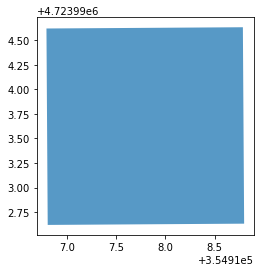

In [88]:
try:
    mugdf.plot(alpha=0.75, cmap="tab10")

except:
    print("There are no mapping units")

In [89]:
# Erase overlapping mapping untis
try:
    for p1_idx, p2_idx in combinations(mugdf.geometry.index, 2):
        if mugdf.geometry.loc[p1_idx].intersects(mugdf.geometry.loc[p2_idx]):
            # Store intermediary results back to poly
            mugdf.geometry.loc[p2_idx] -= mugdf.geometry.loc[p1_idx]
    # mugdf is now saved with the new geometry where it does not overlap itself
except:
    print("There are no mapping units")

In [90]:
try:
    mugdf
except:
    print("There are no mapping units")

Begin Final File Output

In [91]:
# Input Final Output Folder Path
rootOut = input("Enter Path of Site in UAS Data Collection (and Year if Applicable) to Write Final Output --- ")
rootOut = rootOut[1:-1]
workingFinal = rootOut + "\\Transects_Working"
transectFinal = rootOut + "\\Transects"

# Create list of variables with folder paths stored
finalfolderList = [workingFinal, transectFinal]

# Iterate through folder list and create folder if it does not already exist
for i in finalfolderList:
    if not os.path.exists(i):
        os.makedirs(i)
        print(str(i) + " created.")
print("Folder creation complete.")


Enter Path of Site in UAS Data Collection (and Year if Applicable) to Write Final Output --- "G:\.shortcut-targets-by-id\0B6-MI-dco6FLWkZmTDZ4MFhRU1k\7. SaltMUAS_share\UAS Data Collection\Essex Bay\GIS_Data\2021"
Folder creation complete.


In [92]:
# Specify date in the name of the shapefile

# Use previously defined workIn variable to name file
outShape = workingFinal + r"\\" + workIn + "_Transects_Final.shp"
outMu = workingFinal + r"\\" + workIn + "_mu_Final.shp"

polygdf.to_file(outShape)

try:
    mugdf.to_file(outMu)
except:
    print("There are no mapping units")
